In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as fitter
from scipy.stats import norm
from os import path
import re

import seaborn as sns
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper")

import matplotlib
matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':12})
matplotlib.rc('mathtext',**{'default':'regular'})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from numpy import genfromtxt

def linear_calib(x):
    """Linear calibration for channels form PHA to energies in MeV"""
    return -0.02942735 + 0.4521013 *x

def from_pha_data(filename):
    """Exports data from Pulse Height analyzer. Note only channel 0 is active."""
    
    col0 = genfromtxt(filename, delimiter=',', skip_header=1, usecols=(0))
    col1 = genfromtxt(filename, delimiter=',', skip_header=1, usecols=(1))
    
    # Cut out noise from Magnese...
    #if re.match(r".*Mn.*", filename):
        #print("Reducing noise from Magnese source")
        #col0 = col0[200:]
        #col1 = col1[200:]
        
    
    # for safe measure
    col0 = col0[~np.isnan(col0)]
    col1 = col1[~np.isnan(col1)]
    return col0, col1

def find_peaks(energies, counts):
    """
    Determines the first and second peak by first finding this highest peak. Then give the index
    where the derivative changes signs and determines next peak in index range. Ignore second peak
    if source does not contain second peak.
    
    """
    
    peak1_idx = np.argmax(counts)
    peak1 = energies[peak1_idx]
    
    holder = np.max(counts)
    
    gap_idx1 = 0
    gap_idx2 = 0
    
    for i, val in reversed(list(enumerate(counts[:peak1_idx]))):
        if (holder < val):
            gap_idx1 = i
            break
        holder = val

    holder = np.max(counts)
    
    for i, val in enumerate(counts[peak1_idx+2:]):
        if (holder < val):
            gap_idx2 = i
            break
        holder = val
        
    peak2_count = [np.max(counts[peak1_idx+gap_idx2:])]
    peak2_idxs = zip(*np.where(counts == peak2_count))
    
    peak2_idxs = np.array(list(peak2_idxs)).flatten()
    
    for loc in peak2_idxs:
        if energies[loc] > peak1:
            peak2 = energies[loc]
            peak2_idx = loc

            
    #-------------
    gap_idx3 = 0
    gap_idx4 = 0
    
    holder2 = counts[peak2_idx]
    for i, val in reversed(list(enumerate(counts[peak1_idx+gap_idx2:peak2_idx]))):
        if (holder < val):
            gap_idx3 = i
            break
        holder2 = val
    
    for i, val in enumerate(counts[peak2_idx+2:]):
        if (holder < val):
            gap_idx4 = i
            break
        holder2 = val
    
    
    return peak1, peak2, gap_idx1, peak1_idx+gap_idx2, peak2_idx-gap_idx3, peak2_idx+gap_idx4

def extract_info(filename):
    """
    Extracts data, peak locations, and recalibrates PHA channels to MeV conversion.
    
    """
    col0, col1 = from_pha_data(filename)
    
    col1 = remove_bg(np.array(col1))
    
    peak1, peak2, gap_idx1, gap_idx2, gap_idx3, gap_idx4 = find_peaks(col0, col1)
    
    return col0, col1, peak1, peak2, gap_idx1, gap_idx2, gap_idx3, gap_idx4


def remove_bg(counts):
    _, bg = from_pha_data("background_1min.csv")
    
    if len(bg) > len(counts):
        print("here")
        arr = bg[:len(counts)].copy()
    elif len(bg) <len(counts):
        print("now here")
        arr = np.pad(bg, (0, bg.shape-counts.shape), 'constant')
    else:
        return np.abs(counts - bg)
    return np.abs(counts - arr)

Background difference:  11.02565034906915


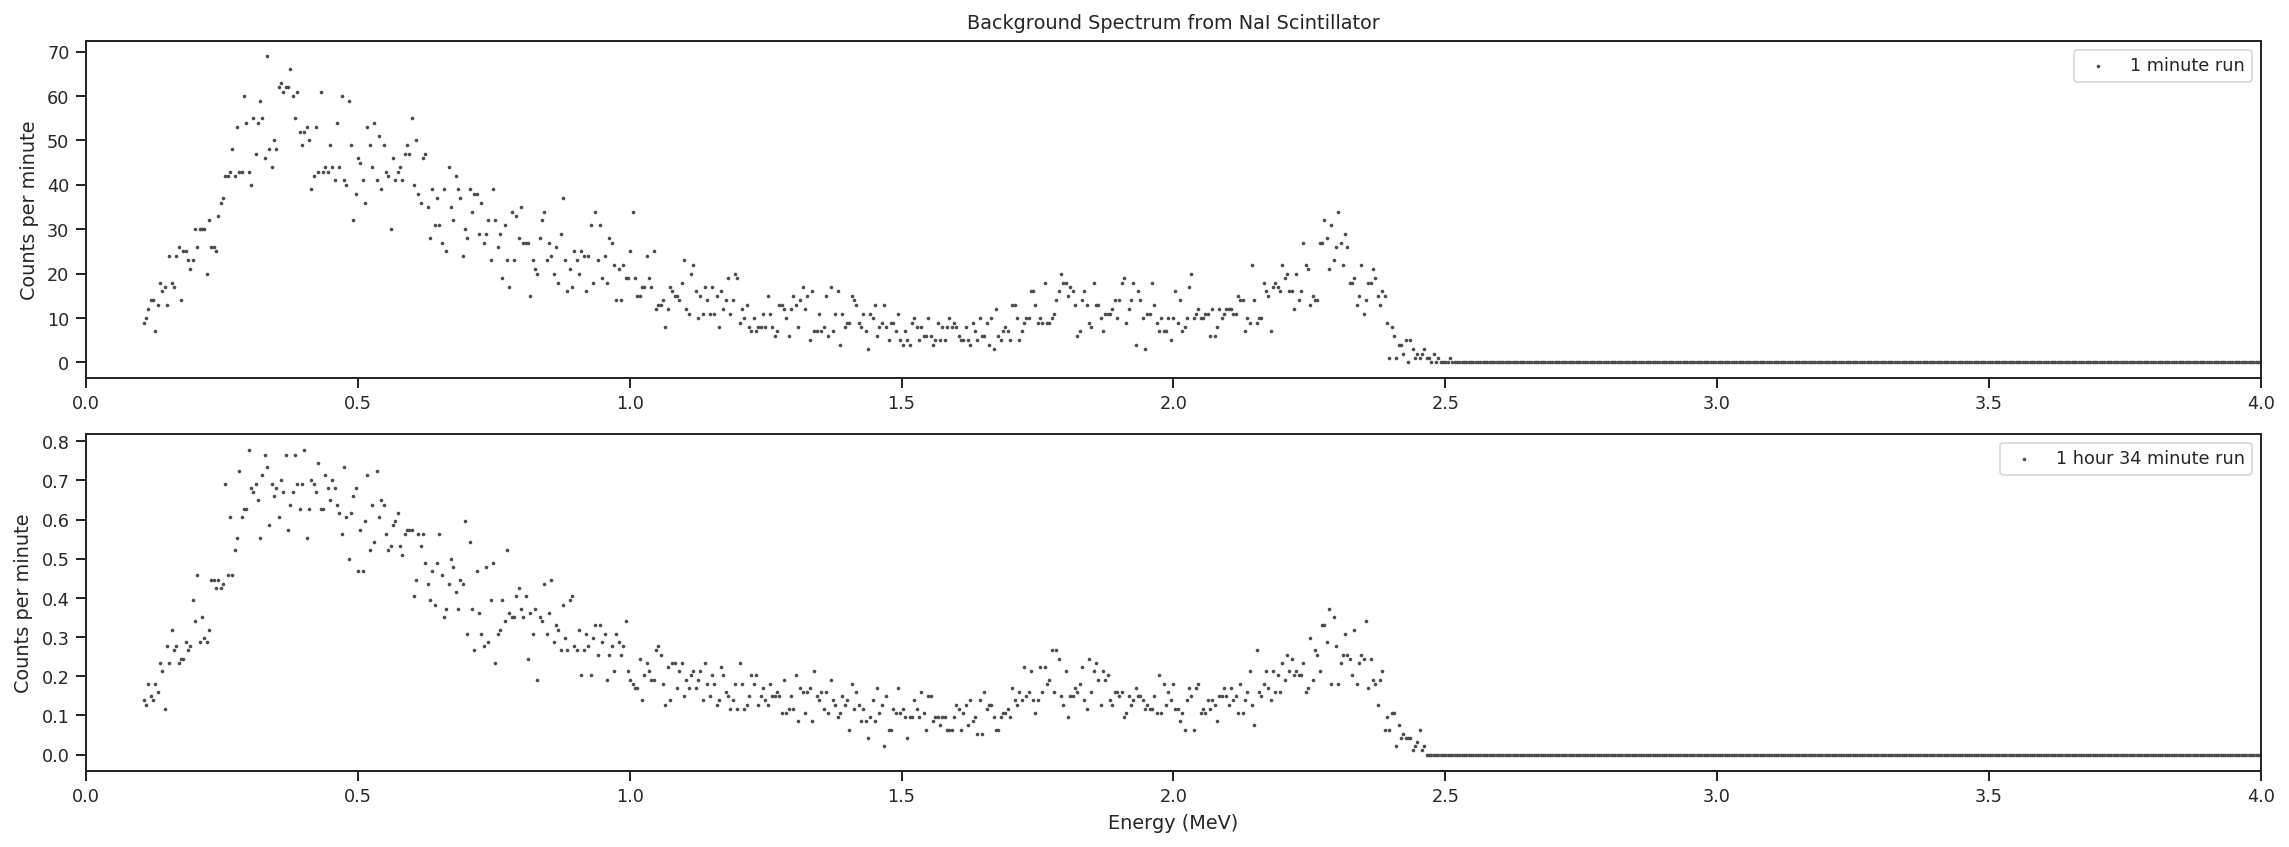

In [3]:
# Removing background noise
# Maganese have bad data...
# Argue that background subtraction is very little...
# Will use background subtraction for 1min
# Note that over long periods of time, background becomes neglegible ~ counts/min -> 0
# 


bg_1min = from_pha_data("background_1min.csv")
bg_1hr = from_pha_data("background_1hr33m50s.csv")


plt.subplots(1, 1, sharex=True, figsize=(16,6))
plt.subplot(211)
plt.scatter(linear_calib(bg_1min[0]), bg_1min[1], s=1, c="0.3", label="1 minute run")
plt.legend()
plt.xlim(0,4)
plt.ylabel("Counts per minute")
plt.title("Background Spectrum from NaI Scintillator")
plt.tight_layout()

plt.subplot(212)
plt.scatter(linear_calib(bg_1hr[0]), bg_1hr[1]/94, s=1, c="0.3", label="1 hour 34 minute run")
plt.legend()
plt.xlim(0,4)
plt.xlabel("Energy (MeV)")
plt.ylabel("Counts per minute")
plt.tight_layout()

print("Background difference: ",
     np.mean(np.abs(bg_1min[1]-bg_1hr[1]/94)))

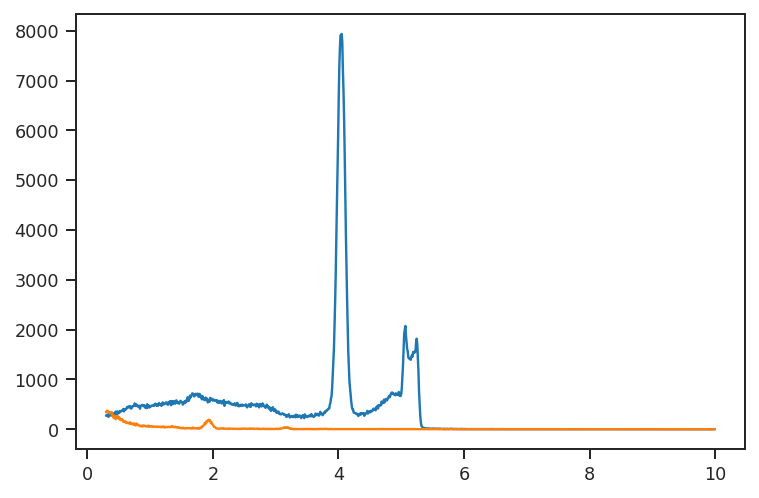

In [4]:
plt.plot(*from_pha_data("8-6Mn54data.csv"))
plt.plot(*from_pha_data("8-6rv_Mn.csv"))

In [5]:
# Fitting gaussian to each source to get true peak
# If peak finder breaks... input values manually...
def gauss_model(x, height, mean, sigma):
    return  height * np.sqrt(2*np.pi) * sigma * norm.pdf(x, mean, sigma)

def fit_sources(channel, counts):
    """
    Fits source to gaussiam curve and returns fitted gaussian parameters.
    
    """
    #err = np.mean(np.diff(channel)) # error in bins
    
    par, cov = fitter.curve_fit(gauss_model, channel, counts, maxfev=3000)
    plt.figure()
    plt.scatter(channel, counts)
    plt.plot(channel, gauss_model(channel, *par))
    plt.show()
    
    return par, cov

def second_fit_data(energies, par):
    """
    Returns only middle portion of gaussian fitted parameters.
    
    """
    slice_idx = round(len(energies)/5)
    energies = energies[slice_idx:-slice_idx]
    counts = gauss_model(energies[slice_idx:-slice_idx], *par)
    
    return energies, counts

In [6]:
na_data = extract_info("8-6rv_Na.csv")
cs_data = extract_info("8-6rv_Cs.csv")
co_data = extract_info("8-6rv_Co.csv")
mn_data = extract_info("8-6rv_Mn.csv")

here


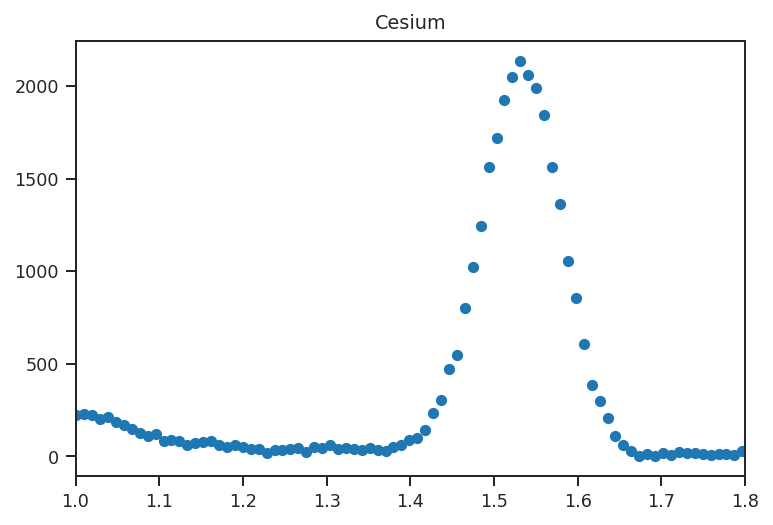

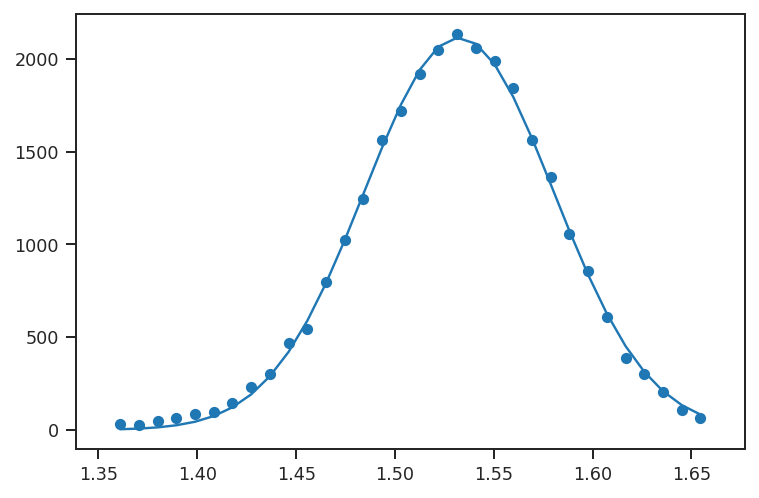

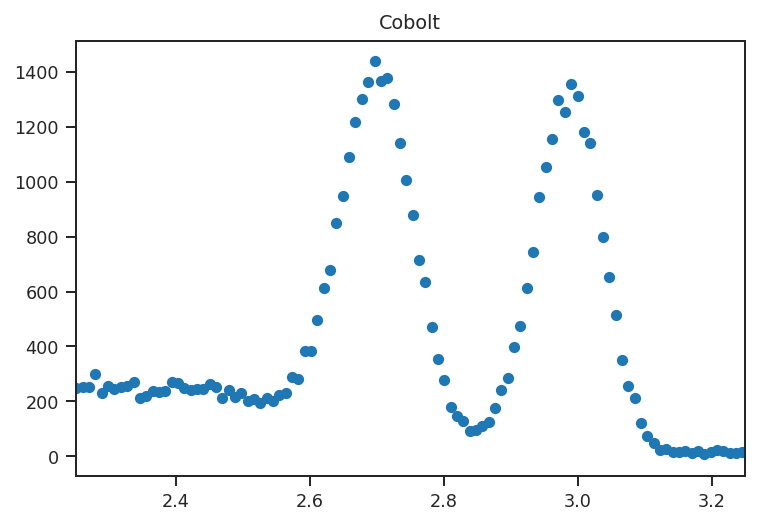

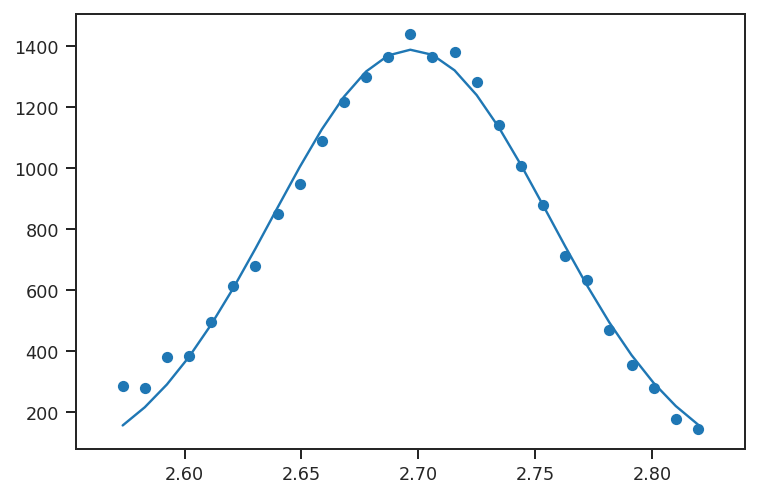

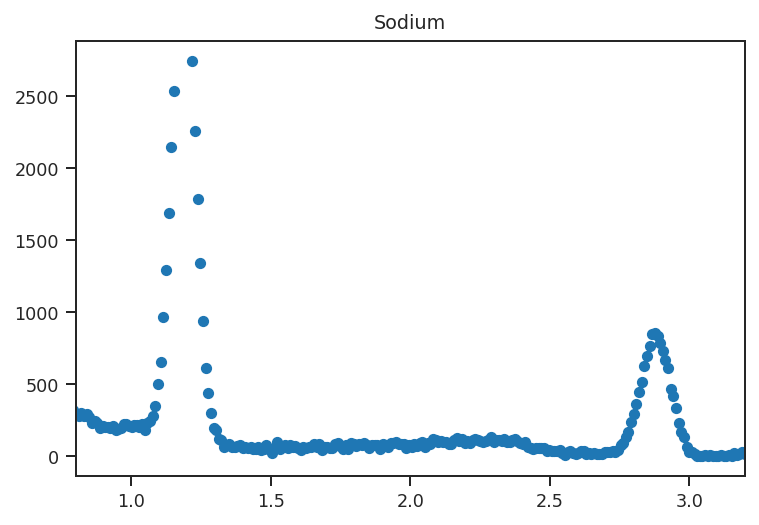

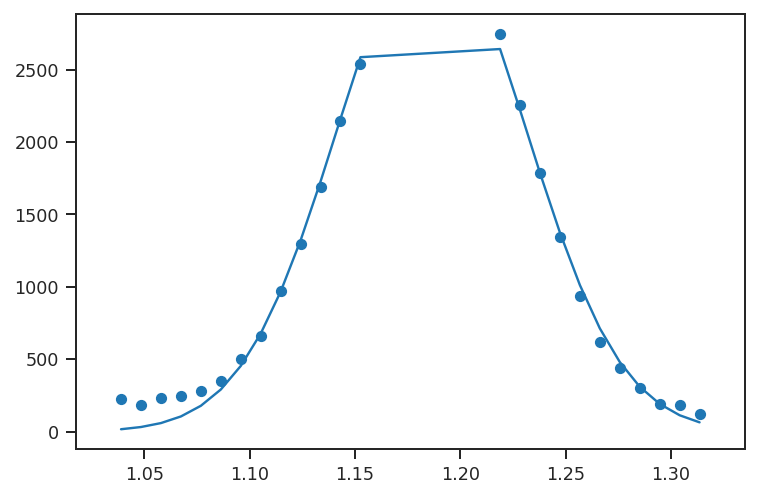

'\nplt.title("Magnese")\nplt.scatter(mn_data[0], mn_data[1])\nplt.xlim(2,4)\nmn_par1, mn_cov1 = fit_sources(mn_data[0][mn_data[4]-15:mn_data[5]+15], mn_data[1][mn_data[4]-15:mn_data[5]+15])\n'

In [7]:
# Fitting gaussian to each source to get true peak
# data = [channel], [counts], peak1, peak2, gap_idx1, gap_idx2

plt.title("Cesium")
plt.scatter(cs_data[0], cs_data[1])
plt.xlim(1,1.8)
cs_par1, cs_cov1 = fit_sources(cs_data[0][cs_data[4]:cs_data[5]], cs_data[1][cs_data[4]:cs_data[5]])


plt.title("Cobolt")
plt.scatter(co_data[0], co_data[1])
plt.xlim(2.25,3.25)
co_par1, co_cov1 = fit_sources(co_data[0][co_data[4]:co_data[5]], co_data[1][co_data[4]:co_data[5]])

plt.title("Sodium")
plt.scatter(na_data[0], na_data[1])
plt.xlim(.8,3.2)
na_par1, na_cov1 = fit_sources(na_data[0][na_data[4]:na_data[5]], na_data[1][na_data[4]:na_data[5]])


"""
plt.title("Magnese")
plt.scatter(mn_data[0], mn_data[1])
plt.xlim(2,4)
mn_par1, mn_cov1 = fit_sources(mn_data[0][mn_data[4]-15:mn_data[5]+15], mn_data[1][mn_data[4]-15:mn_data[5]+15])
"""

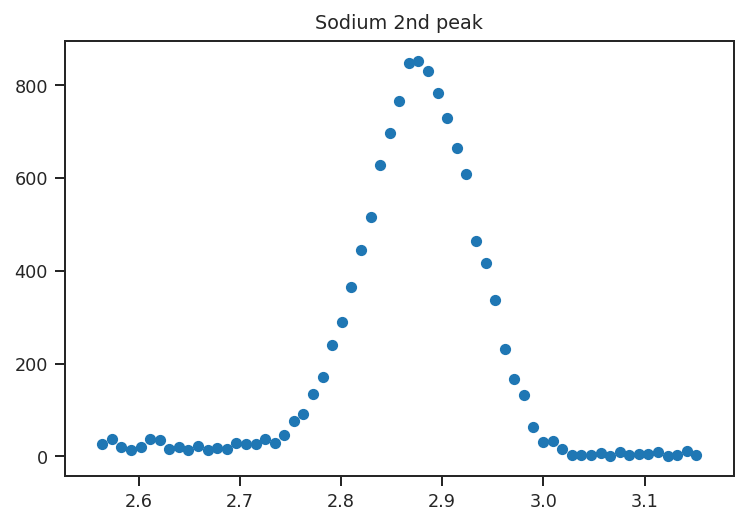

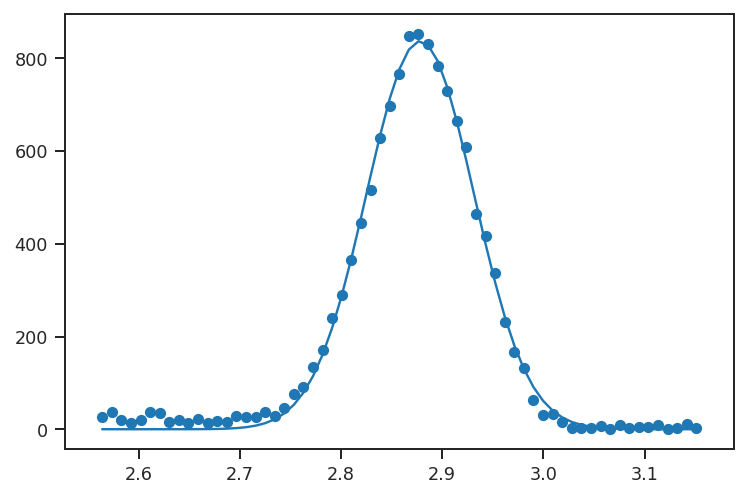

[8.37574799e+02 2.87828190e+00 5.31166800e-02]


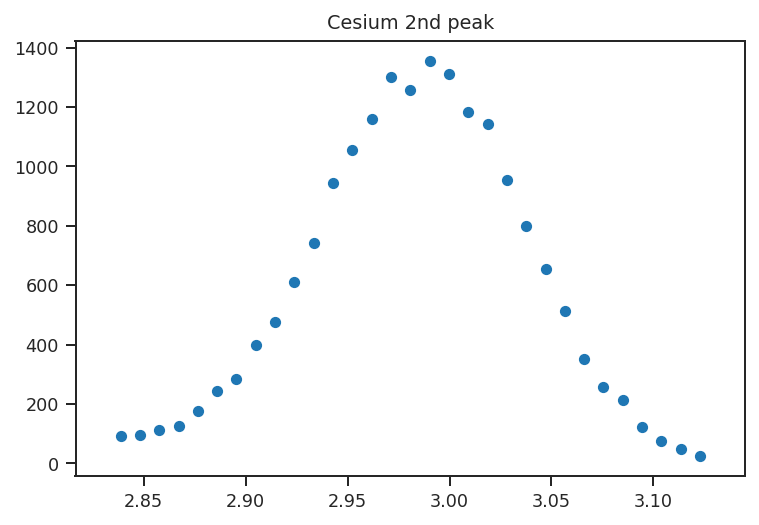

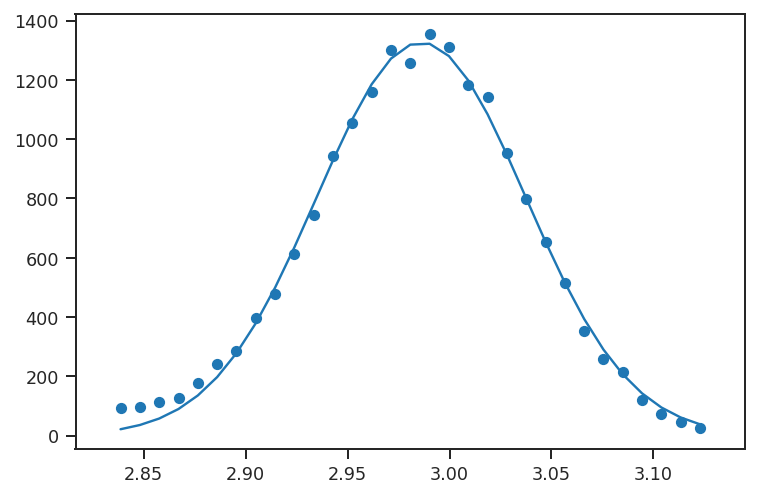

[1.32600187e+03 2.98611010e+00 5.12515545e-02]


In [8]:
# Fitting second peaks

plt.title("Sodium 2nd peak")
plt.scatter(na_data[0][na_data[6]+130:na_data[7]+30], na_data[1][na_data[6]+130:na_data[7]+30])
na_par2, na_cov2 = fit_sources(na_data[0][na_data[6]+130:na_data[7]+30], na_data[1][na_data[6]+130:na_data[7]+30])
print(na_par2)

plt.title("Cesium 2nd peak")
plt.scatter(co_data[0][co_data[6]:co_data[7]+15], co_data[1][co_data[6]:co_data[7]+15])
co_par2, co_cov2 = fit_sources(co_data[0][co_data[6]:co_data[7]+15], co_data[1][co_data[6]:co_data[7]+15])
print(co_par2)

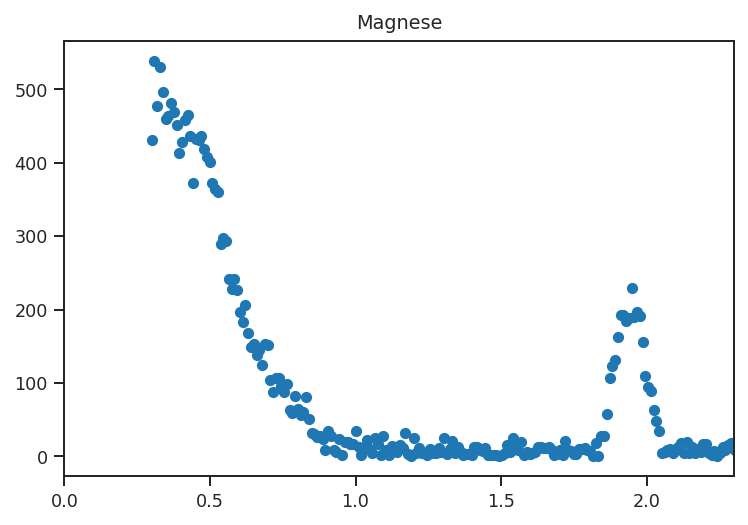

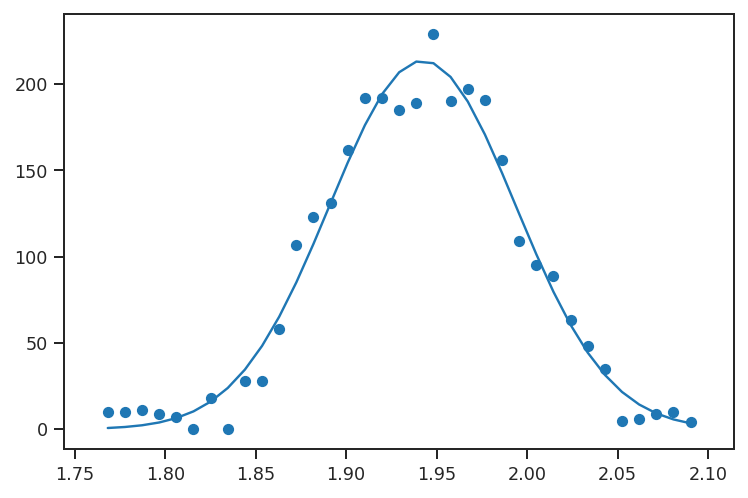

In [9]:
# Reanalyze Mn seperately.... maybe using another file? 
# New 2min run of Mn with background removed.

mn_data2 = extract_info("8-6Mn_rv2min.csv")

plt.title("Magnese")
plt.scatter(mn_data2[0], mn_data2[1])
plt.xlim(0, 2.3)
mn_par1, mn_cov1 = fit_sources(mn_data2[0][155:190], mn_data2[1][155:190])


In [10]:
print(cs_par1[0], np.sqrt(np.diag(cs_cov1))[0])
print(na_par1[0], np.sqrt(np.diag(na_cov1))[0])
print(na_par2[0], np.sqrt(np.diag(na_cov2))[0])
print(mn_par1[0], np.sqrt(np.diag(mn_cov1))[0])

2116.0623032598214 12.785207396010447
3425.674204836248 89.72803374564131
837.5747990610374 6.988169939840645
213.46500249084193 5.088395705679497


# FWHM 

In [11]:
# Return FWHM, par = [height, mean, sigma]
def fwhm(mean, sigma):
    return 2*np.sqrt(np.log(2))*sigma/mean

def div_err( y, x, err_y, err_x):
    fwhm = 2*np.sqrt(np.log(2))*x/y
    return np.sqrt((err_x/x)**2 + (err_y/y)**2)*2*np.sqrt(np.log(2))*fwhm


na_fwhm1 = fwhm(*na_par1[1:])
na_err1 = div_err(*na_par1[1:], *np.sqrt(np.diag(na_cov1))[1:])

na_fwhm2 = fwhm(*na_par2[1:])
na_err2 = div_err(*na_par2[1:], *np.sqrt(np.diag(na_cov2))[1:])

cs_fwhm1 = fwhm(*cs_par1[1:])
cs_err1 = div_err(*cs_par1[1:], *np.sqrt(np.diag(cs_cov1))[1:])

co_fwhm1 = fwhm(*co_par1[1:])
co_err1 = div_err(*co_par1[1:], *np.sqrt(np.diag(co_cov1))[1:])

co_fwhm2 = fwhm(*co_par2[1:])
co_err2 = div_err(*co_par2[1:], *np.sqrt(np.diag(co_cov2))[1:])

mn_fwhm1 = fwhm(*mn_par1[1:])
mn_err1 = div_err(*mn_par1[1:], *np.sqrt(np.diag(mn_cov1))[1:])

print("na 1", na_fwhm1, na_err1,
      "\nna 2", na_fwhm2, na_err2,
      "\ncs 1", cs_fwhm1, cs_err1,
      "\nco 1", co_fwhm1, co_err1,
      "\nco 2", co_fwhm2, co_err2,
      "\nmn 2", mn_fwhm1, mn_err1)

na 1 0.06324871424510607 0.0019632364492218604 
na 2 0.030728426456237974 0.000493015413450531 
cs 1 0.052122476160227665 0.000608087072430837 
co 1 0.03651445304487124 0.0009210675104603234 
co 2 0.028578797591456383 0.000586459694893554 
mn 2 0.0441212206850725 0.0020246750456361018


1.6482343877353155e-06 [1.18635422 0.04506334] [4.01693834e-07 7.05092727e-07]

In [12]:
# Find channel corresponding to gaussian fitted peaks
"""
def find_nearest(channel, counts, value):
    idx = (np.abs(counts - value)).argmin()
    print(value)
    return channel[idx]

na_peak1 = find_nearest(na_data[0], na_data[1], na_par1[0])
na_peak2 = find_nearest(na_data[0], na_data[1], na_par2[0])
cs_peak1 = find_nearest(cs_data[0], cs_data[1], cs_par1[0])
co_peak1 = find_nearest(co_data[0], co_data[1], co_par1[0])
co_peak2 = find_nearest(co_data[0], co_data[1], co_par2[0])
mn_peak1 = find_nearest(mn_data[0], mn_data[1], mn_par1[0])

"""

'\ndef find_nearest(channel, counts, value):\n    idx = (np.abs(counts - value)).argmin()\n    print(value)\n    return channel[idx]\n\nna_peak1 = find_nearest(na_data[0], na_data[1], na_par1[0])\nna_peak2 = find_nearest(na_data[0], na_data[1], na_par2[0])\ncs_peak1 = find_nearest(cs_data[0], cs_data[1], cs_par1[0])\nco_peak1 = find_nearest(co_data[0], co_data[1], co_par1[0])\nco_peak2 = find_nearest(co_data[0], co_data[1], co_par2[0])\nmn_peak1 = find_nearest(mn_data[0], mn_data[1], mn_par1[0])\n\n'

# LINEAR CALIBRATION

[-0.03270555  0.45293546]
[0.01710487 0.00740634]
[0.50463635 0.66136911 0.84701761 1.18879693 1.2709704  1.31980961]
[0.00636365 0.00023089 0.00701761 0.01879693 0.0090296  0.01019039]


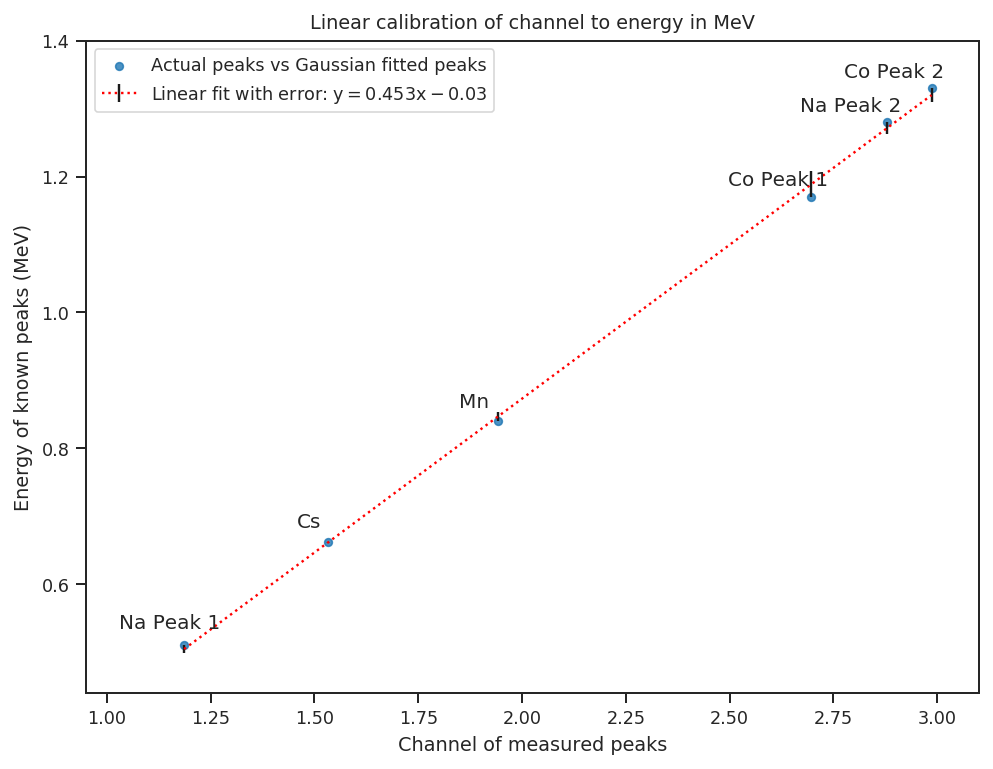

In [13]:
# Performing linear calibration with known energy peaks.
# [na1, na2, cs, co1, co2, mn]

def linear_model(x, a, b):
    return a + b*x

def inv_linear_model(y, a, b):
    return (y-a)/b

def scalar_model(x, a):
    return a*x

source = ["Na Peak 1", "Cs", "Mn", "Co Peak 1", "Na Peak 2", "Co Peak 2"]

y = np.array([0.511, 0.6616, 0.84, 1.17, 1.28, 1.33]) # [na1, na2, cs, co1, co2, mn] known energies of peak sources
x = np.array([na_par1[1], cs_par1[1], mn_par1[1], co_par1[1], na_par2[1], co_par2[1]]) # gaussian estimated peak values

#linear_y = np.array([0.511, 0.6616, 1.17, 1.28, 1.33]) # known energies of peak sources
#linear_x = np.array([na_par1[1], cs_par1[1], co_par1[1], na_par2[1], co_par2[1]])



par_lin, cov_lin = fitter.curve_fit(linear_model, x, y, maxfev=3000)
#par_lin_mn, cov_lin_mn = fitter.curve_fit(scalar_model, mn_par1[1], 0.84, maxfev=3000)
print(par_lin)
print(np.sqrt(np.diag(cov_lin)))

errs = np.abs(y - linear_model(x, *par_lin))

plt.figure(figsize=(8,6))
plt.scatter(x, y, s=15, label="Actual peaks vs Gaussian fitted peaks", marker='o', alpha=0.8)
plt.errorbar(x, linear_model(x, *par_lin), yerr=errs, 
             c='r', ls=':', fmt='-.', ecolor='0.1',
             label=r"Linear fit with error: $y = 0.453x -0.03$")
plt.plot()
plt.xlim(.95,3.1)
plt.ylim(.44, 1.4)

for i, txt in enumerate(source):   
    plt.annotate(txt, (x[i]* (1 - 0.03), y[i]* (1 - 0.01)),
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    
#plt.plot(x, linear_model(x, *par_lin), 'g:', label="Linear fit")
plt.legend()
plt.title("Linear calibration of channel to energy in MeV")
plt.xlabel("Channel of measured peaks")
plt.ylabel("Energy of known peaks (MeV)")

print(linear_model(x, *par_lin))
print(errs)



In [14]:
# Second gaussian fit.
# not noticing enough difference to parameters....
"""
cs_energies2 = cs_data[0][cs_data[4]:cs_data[5]]
cs_counts2 = gauss_model(cs_data[0][cs_data[4]:cs_data[5]], *cs_par1)
cs_par2 = fit_sources(cs_energies2[11:-5], cs_counts2[11:-5])
print(cs_par1, cs_par2)


na_energies2 = na_data[0][na_data[4]:na_data[5]]
na_counts2 = gauss_model(na_data[0][na_data[4]:na_data[5]], *na_par1)
na_par2 = fit_sources(na_energies2[10:-7], na_counts2[10:-7])
print(na_par1, na_par2)


# testing more data points in sodium range but not getting any difference
imaginary_nums = np.linspace(1.05, 1.30, 50)
im_par2 = fit_sources(imaginary_nums, gauss_model(imaginary_nums, *na_par1))
print(im_par2)
"""

'\ncs_energies2 = cs_data[0][cs_data[4]:cs_data[5]]\ncs_counts2 = gauss_model(cs_data[0][cs_data[4]:cs_data[5]], *cs_par1)\ncs_par2 = fit_sources(cs_energies2[11:-5], cs_counts2[11:-5])\nprint(cs_par1, cs_par2)\n\n\nna_energies2 = na_data[0][na_data[4]:na_data[5]]\nna_counts2 = gauss_model(na_data[0][na_data[4]:na_data[5]], *na_par1)\nna_par2 = fit_sources(na_energies2[10:-7], na_counts2[10:-7])\nprint(na_par1, na_par2)\n\n\n# testing more data points in sodium range but not getting any difference\nimaginary_nums = np.linspace(1.05, 1.30, 50)\nim_par2 = fit_sources(imaginary_nums, gauss_model(imaginary_nums, *na_par1))\nprint(im_par2)\n'

In [15]:
def linear_calib(x):
    """Linear calibration for channels form PHA to energies in MeV"""
    return par_lin[0] + par_lin[1]*x

def scalar_calib(x):
    """Scalar calibration for channels to MeV for Mn only. (Mn data set seems to be outliers.)"""
    return par_lin_mn[0]*x

# COMPTON BACK SCATTER

In [16]:
# Compton scattering values
def back_scatter(e):
    mecsq = 0.511
    return e/(1+e/(mecsq)*(1-np.cos(np.pi)))

def find_back_scatter(channel, counts, peak_start):
    return channel[np.argmax(counts[0:peak_start])]

y = np.array([0.511, 0.6616, 0.84, 1.17, 1.28, 1.33]) # [na1, na2, cs, co1, co2, mn] known peaks
# back scatter values [na, cs, co, mn]

na_bs = linear_calib(find_back_scatter(na_data[0], na_data[1], na_data[4]))
#cs_bs = linear_calib(find_back_scatter(cs_data[0], cs_data[1], cs_data[4]))
cs_bs = linear_calib(0.47998)
co_bs = linear_calib(find_back_scatter(co_data[0][5:], co_data[1][5:], co_data[4]))

mn_bs = linear_calib(0.470508)
    

# COMPTON EDGE

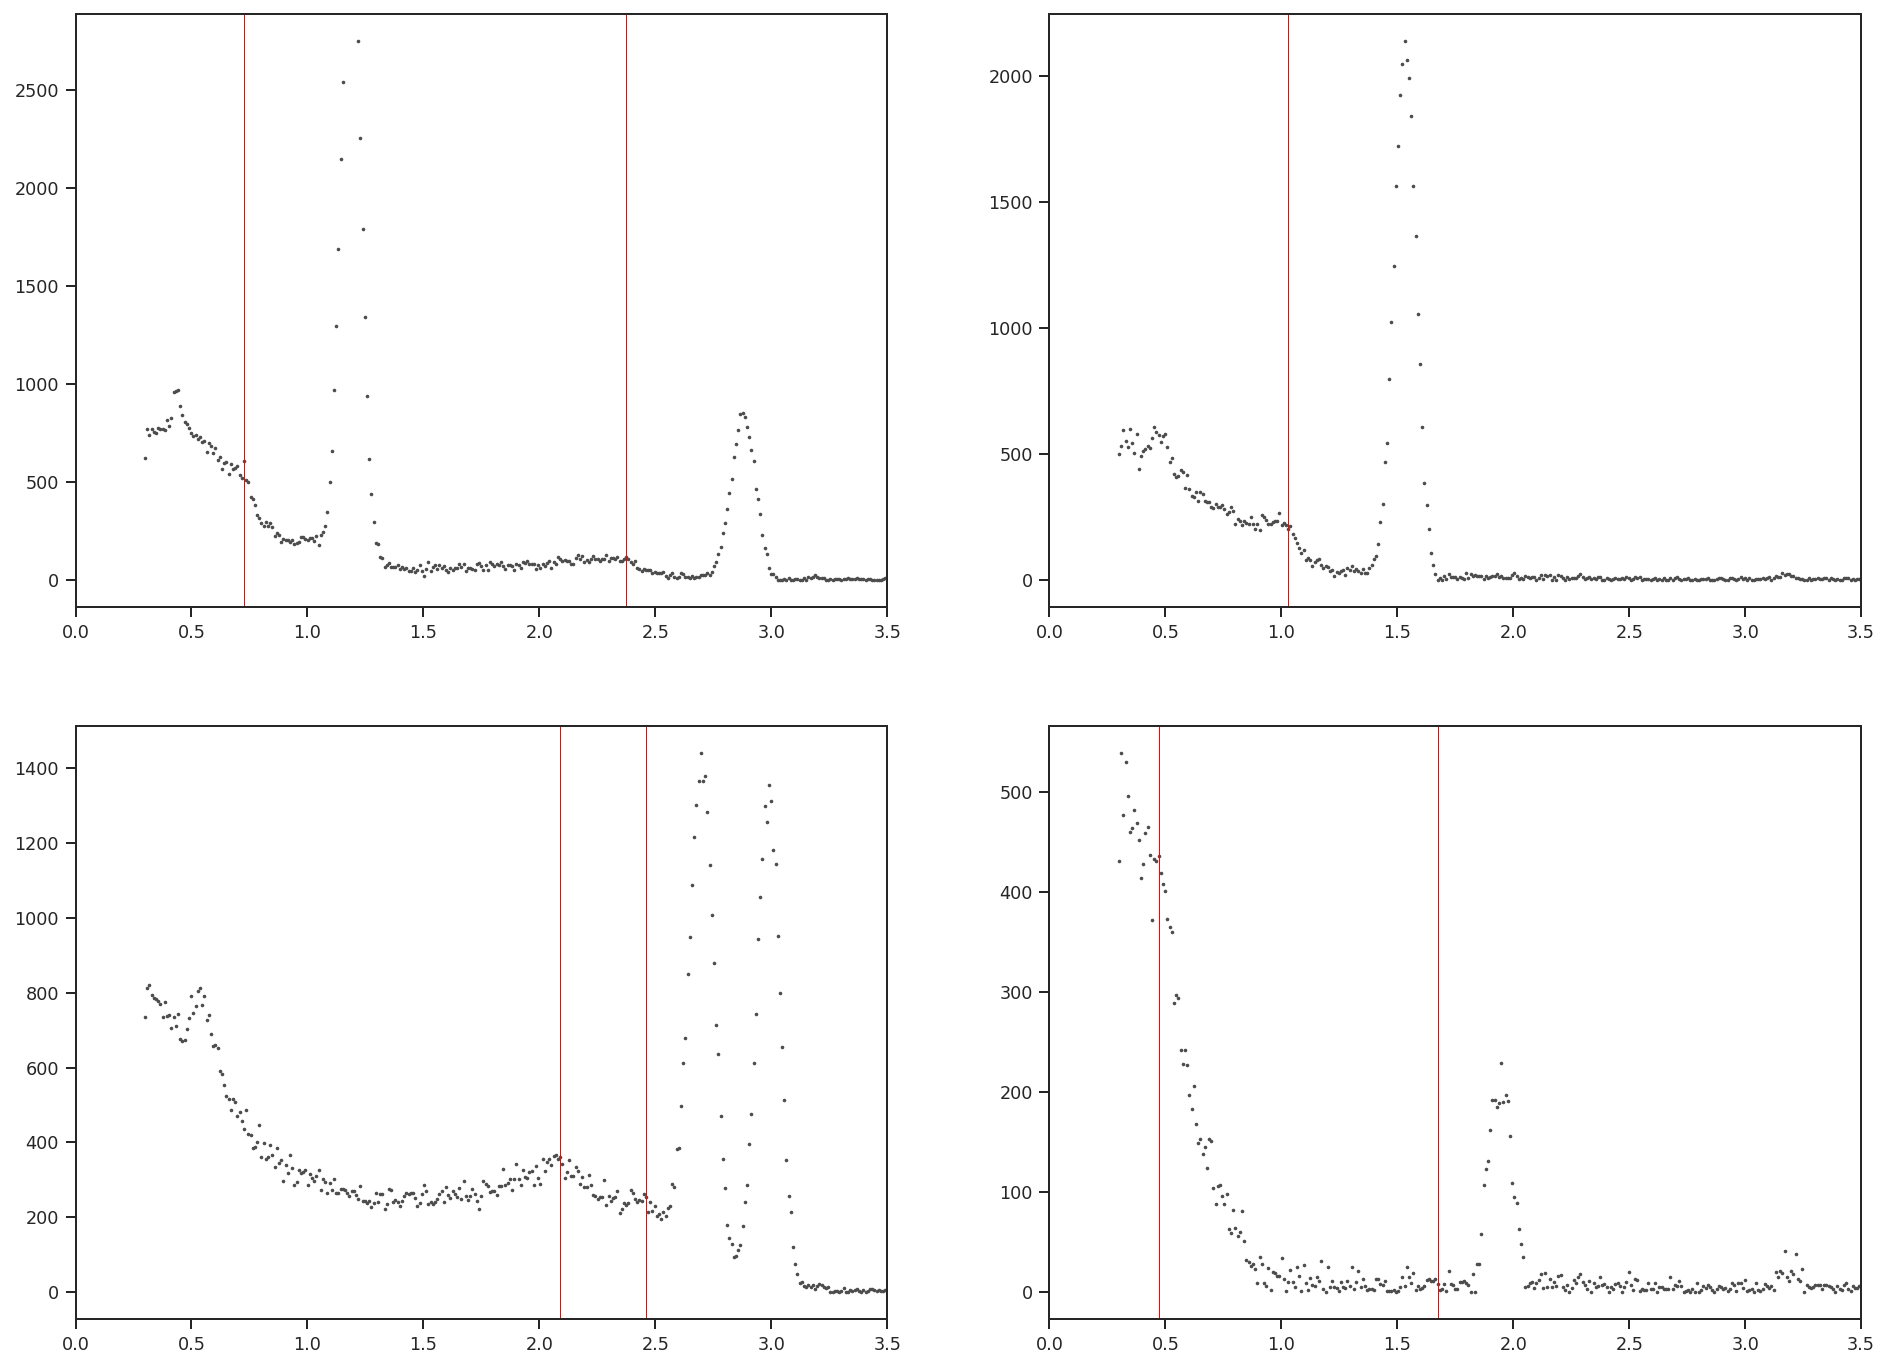

In [17]:
# COMPTON EDGES
plt.subplots(2, 2, sharex=True, figsize=(16,12))
plt.subplot(221)
plt.scatter(na_data[0], na_data[1], s=1, c="0.3",)
plt.axvline(x=0.72627, linewidth=.5, color='r', label="Backscatter peak")
plt.axvline(x=2.37451, linewidth=.5, color='r', label="Backscatter peak")
plt.xlim(0,3.5)

plt.subplot(222)
plt.scatter(cs_data[0], cs_data[1], s=1, c="0.3",)
plt.axvline(x=1.02939, linewidth=.5, color='r', label="Backscatter peak")
plt.xlim(0,3.5)

plt.subplot(223)
plt.scatter(co_data[0], co_data[1], s=1, c="0.3",)
plt.axvline(x=2.09033, linewidth=.5, color='r', label="Backscatter peak")
plt.axvline(x=2.45977, linewidth=.5, color='r', label="Backscatter peak")
plt.xlim(0,3.5)


plt.subplot(224)
plt.scatter(mn_data2[0], mn_data2[1], s=1, c="0.3",)
plt.axvline(x=1.67354, linewidth=.5, color='r', label="Backscatter peak")
plt.axvline(x=0.470508, linewidth=.5, color='r', label="Backscatter peak")
plt.xlim(0,3.5)

comp_edges = [0.72627, 2.37451, 1.02939, 2.09033, 2.45977, 1.67354]  #[na1, na2, cs, co1, co2, mn]

# looking for peaks

Na_peaks_obs = [Na_volts[np.argmax(Na_counts[0:500])],Na_volts[np.argmax(Na_counts[460:1000])]]
Na_peaks = [0.511, 1.28]


par0 = np.array([0.511, 1.28]) # initial guess for parameters
par, cov = fitter.curve_fit(linear_model, Na_peaks_obs, Na_peaks, par0)
print(par)
par = [.3483, .22932]
Cs_volts = linear_model(Cs_volts, par[0], par[1])
Co_volts = linear_model(Co_volts, par[0], par[1])
Na_volts = linear_model(Na_volts, par[0], par[1])
Mn_volts = linear_model(Mn_volts, par[0], par[1])

backscatter:  0.16753268892414783 0.18469441361807457 0.21043745359442761 0.18040420891232437
compton edges:  [0.29624789 1.04279424 0.43354169 0.91407904 1.08141151 0.72530006]


Text(0.5, 6.800000000000011, 'Energy (MeV)')

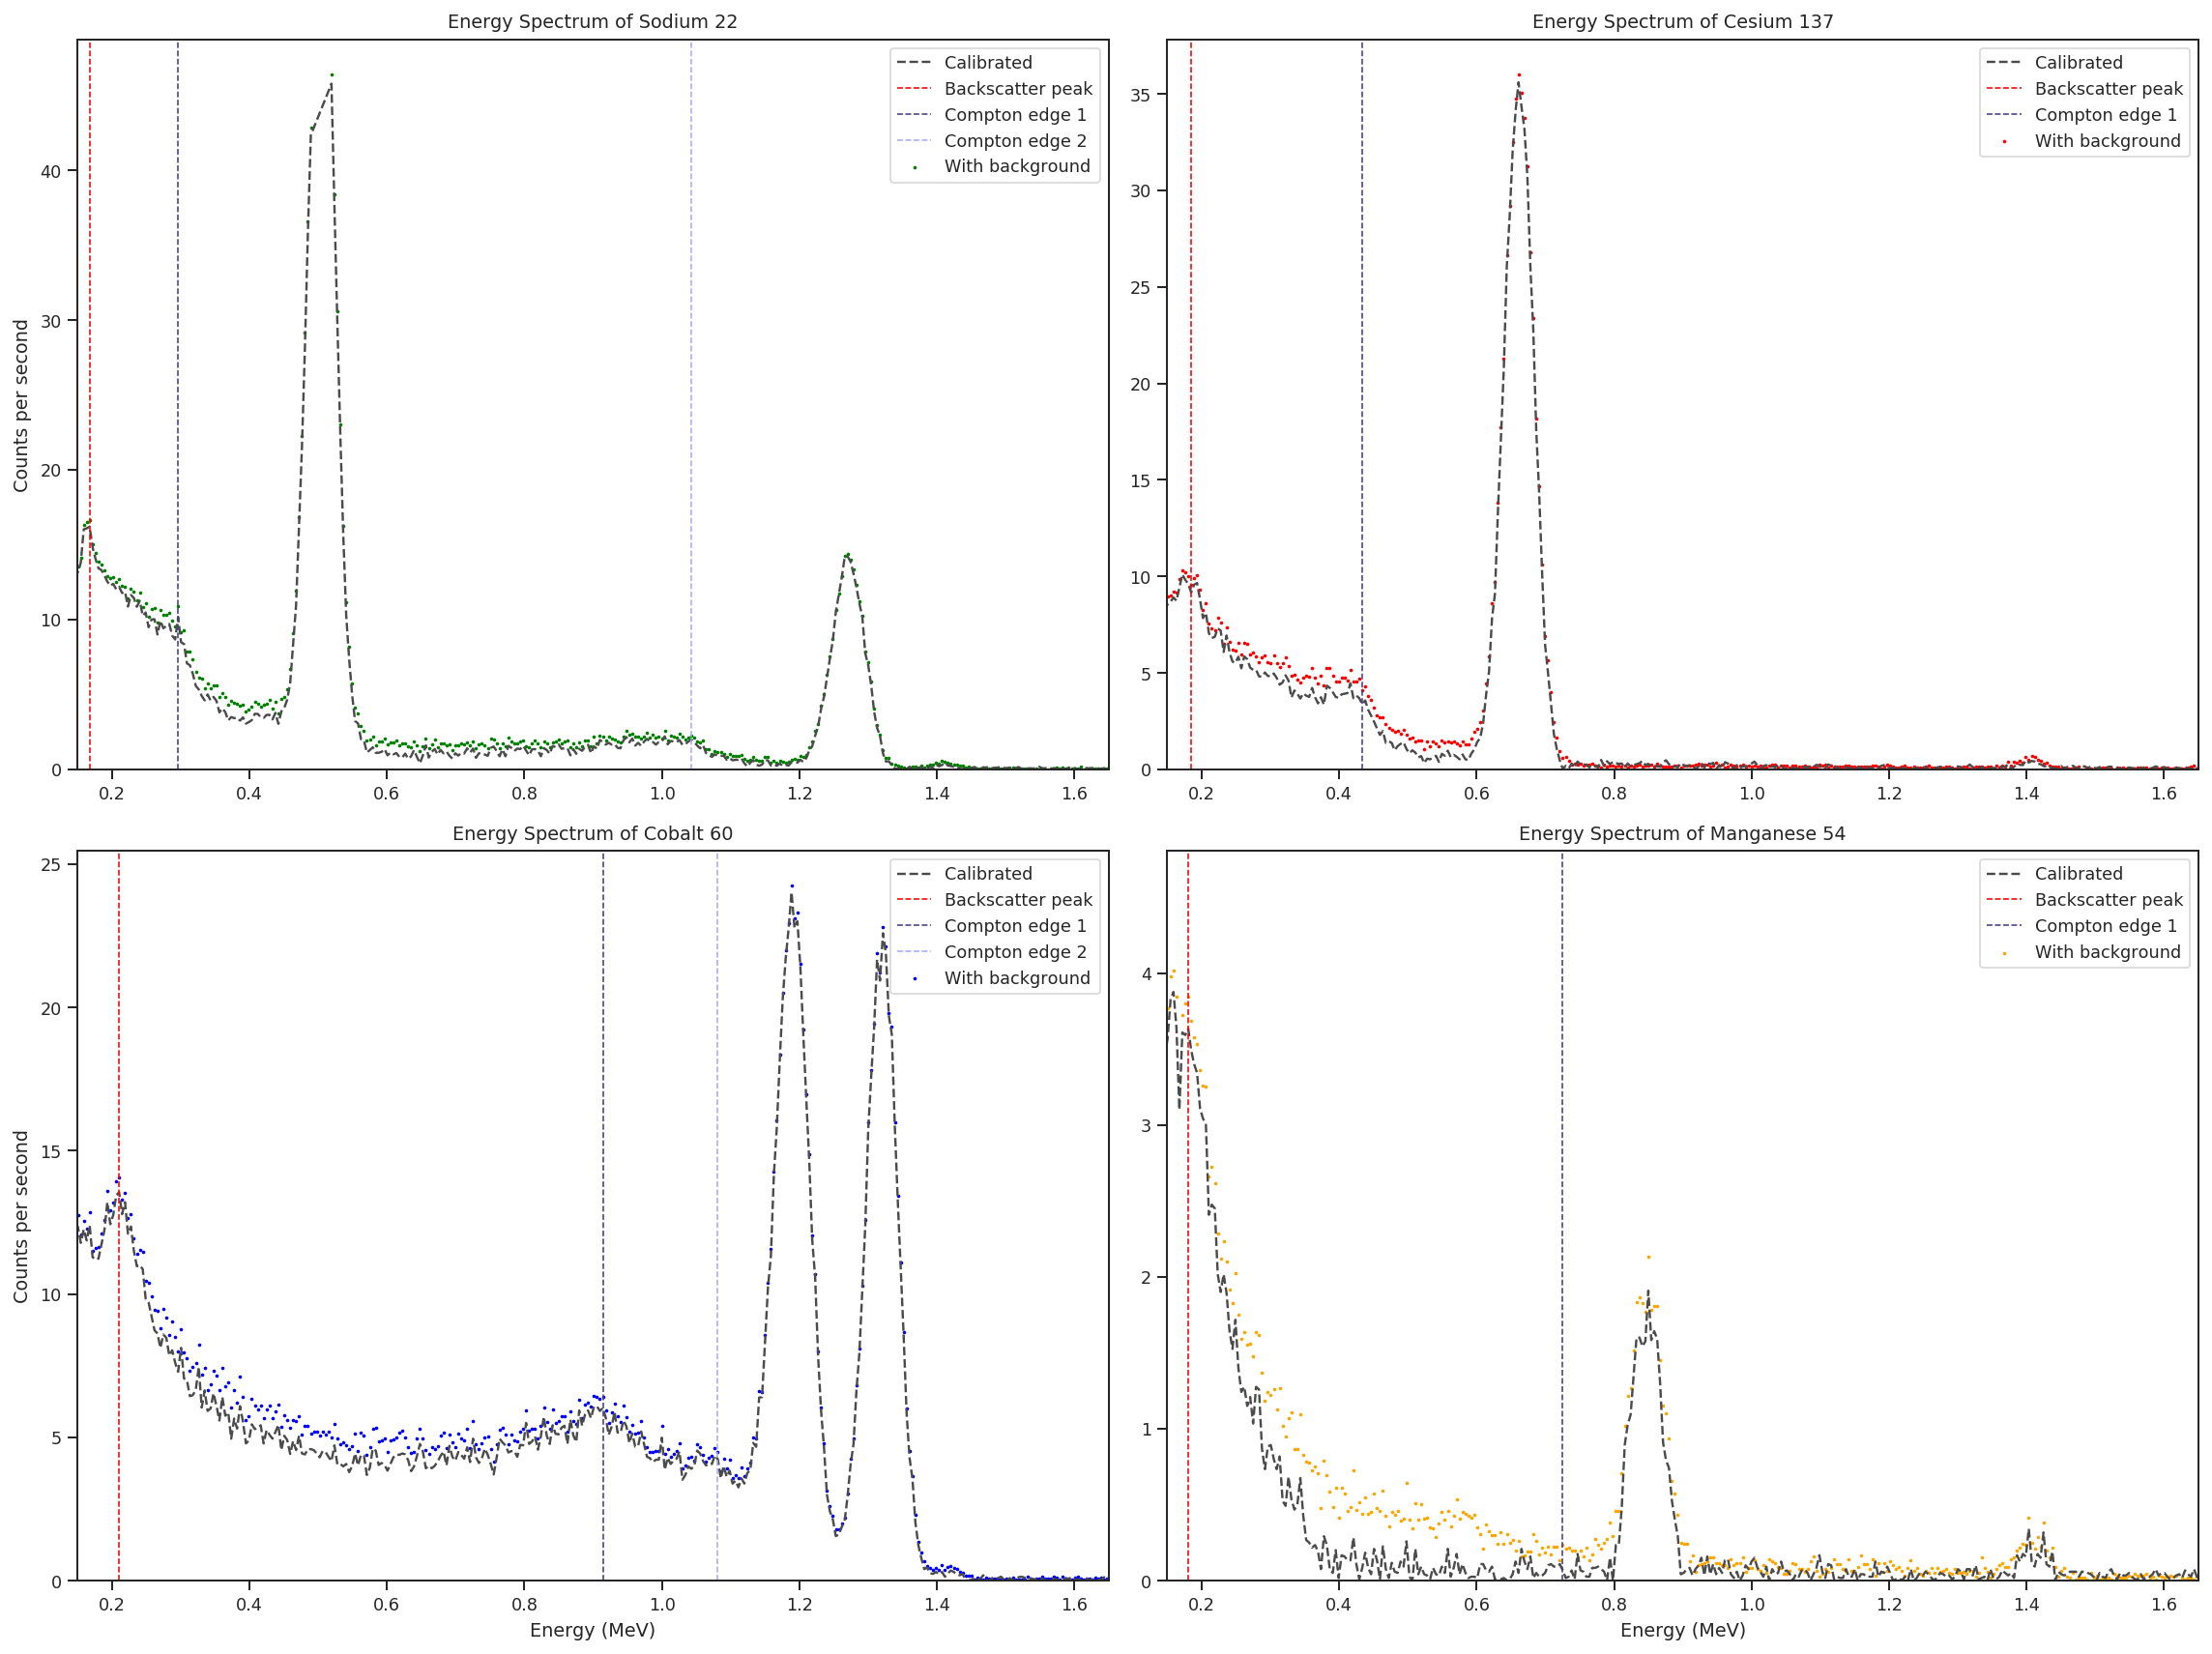

In [24]:
#mn_energies, mn_counts = from_pha_data("8-6rv_Mn.csv")
comp_edges = linear_calib(np.array(comp_edges)) #[na1, na2, cs, co]
print("backscatter: ", na_bs, cs_bs, co_bs, mn_bs)
print("compton edges: ", comp_edges)

def linear_calib(x):
    """Linear calibration for channels form PHA to energies in MeV"""
    return par_lin[0] + par_lin[1]*x

def scalar_calib(x):
    """Scalar calibration for channels to MeV for Mn only. (Mn data set seems to be outliers.)"""
    return par_lin_mn[0]*x

def plot_spectrum(energies, counts, calib_en, calib_ct, comp_bs, color, title, edg1, edg2=0, xlim=[0.15,1.65]):
    
    plt.scatter(energies, counts, s=1, c=color, label="With background")
    plt.plot(calib_en, calib_ct, '--', color="#4C4B4B", label="Calibrated")
    plt.axvline(x=comp_bs, linewidth=.8, ls='--', color='r', label="Backscatter peak")
    plt.axvline(x=edg1, linewidth=.8, ls='--', color='#483D8B', label="Compton edge 1")
    if edg2!=0:
        plt.axvline(x=edg2, linewidth=.8, ls='--', color='#AAAAFF', label="Compton edge 2")
    plt.title(title)
    plt.xlim(*xlim)
    plt.ylim(0)
    plt.legend()
    plt.tight_layout()


plt.subplots(2, 2, sharex=True, figsize=(16,12))

plt.subplot(221)
na_raw = from_pha_data("8-6rv_Na.csv")
plot_spectrum(
    linear_calib(na_raw[0]), na_raw[1]/60, linear_calib(na_data[0]), na_data[1]/60, na_bs,
    'g', "Energy Spectrum of Sodium 22", comp_edges[0], edg2=comp_edges[1])
plt.ylabel('Counts per second')

plt.subplot(222)
cs_raw = from_pha_data("8-6rv_Cs.csv")
plot_spectrum(
    linear_calib(cs_raw[0]), cs_raw[1]/60, linear_calib(cs_data[0]), cs_data[1]/60, cs_bs,
    'r', "Energy Spectrum of Cesium 137", comp_edges[2])

plt.subplot(223)
co_raw = from_pha_data("8-6rv_Co.csv")
plot_spectrum(
    linear_calib(co_raw[0]), co_raw[1]/60, linear_calib(co_data[0]), co_data[1]/60, co_bs,
    'b', "Energy Spectrum of Cobalt 60", comp_edges[3], edg2=comp_edges[4])
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts per second')

plt.subplot(224)
mn_raw = from_pha_data("8-6Mn_rv2min.csv")
plot_spectrum(
    linear_calib(mn_raw[0]), mn_raw[1]/120, linear_calib(mn_data2[0]), mn_data2[1]/120, mn_bs,
    'orange', "Energy Spectrum of Manganese 54", comp_edges[5])
plt.xlabel('Energy (MeV)')

In [19]:
# np.array([na_par1[1], cs_par1[1], co_par1[1], na_par2[1], co_par2[1]])
# np.sqrt(np.diag(na_cov1))
# par_lin, cov_lin
def calib_errors(x, x_err):
    mult_err = np.sqrt((x_err/x)**2+(np.sqrt(np.diag(cov_lin))[1]/par_lin[1])**2)*x*par_lin[1]
    return np.sqrt(mult_err**2+ np.diag(cov_lin)[0])

na1_err = calib_errors(na_par1[1], np.sqrt(np.diag(na_cov1))[1])
na2_err = calib_errors(na_par2[1], np.sqrt(np.diag(na_cov2))[1])
cs1_err = calib_errors(cs_par1[1], np.sqrt(np.diag(cs_cov1))[1])
co1_err = calib_errors(co_par1[1], np.sqrt(np.diag(co_cov1))[1])
co2_err = calib_errors(co_par2[1], np.sqrt(np.diag(co_cov2))[1])
mn1_err = calib_errors(mn_par1[1], np.sqrt(np.diag(mn_cov1))[1])

print(
"na: ", linear_calib(na_par1[1]), na1_err, linear_calib(na_par2[1]), na2_err,
"\ncs:", linear_calib(cs_par1[1]), cs1_err,
"\nco:", linear_calib(co_par1[1]), co1_err, linear_calib(co_par2[1]), co2_err,
"\nmn:", linear_calib(mn_par1[1]), mn1_err, linear_calib(mn_par1[1]), mn1_err,
)

print("a, b", par_lin, np.sqrt(np.diag(cov_lin)))

na:  0.504636350146767 0.01923180124253178 1.270970395029653 0.027332531149281004 
cs: 0.6613691092662846 0.020528239169736597 
co: 1.1887969300010797 0.02629979830281178 1.3198096099474157 0.027960354378231845 
mn: 0.8470176056088023 0.02235887866257447 0.8470176056088023 0.02235887866257447
a, b [-0.03270555  0.45293546] [0.01710487 0.00740634]


In [20]:
comp_edges = np.array([0.72627, 2.37451, 1.02939, 2.09033, 2.45977, 1.67354])  #[na1, na2, cs, co1, co2, mn1]
ch_err = 0.009473*10
comp_errs = []
for edge in comp_edges:
    comp_errs.append(calib_errors(edge, ch_err))
    
print(linear_calib(comp_edges))
print(comp_errs)

[0.29624789 1.04279424 0.43354169 0.91407904 1.08141151 0.72530006]
[0.04650252065746675, 0.04942502499936626, 0.04681534267654177, 0.04871584479918, 0.049653219891456914, 0.04782449084515587]


In [21]:
bs = np.array([find_back_scatter(na_data[0], na_data[1], na_data[4]), 
    0.47998, 
    find_back_scatter(co_data[0][5:], co_data[1][5:], co_data[4]),
    0.470508])
bs_errs = []

for i in bs:
    bs_errs.append(calib_errors(i, ch_err))

print(linear_calib(bs))
print(bs_errs)

[0.16753269 0.18469441 0.21043745 0.18040421]
[0.046306280392291656, 0.04632696887753701, 0.04636116999272117, 0.046321638517722113]


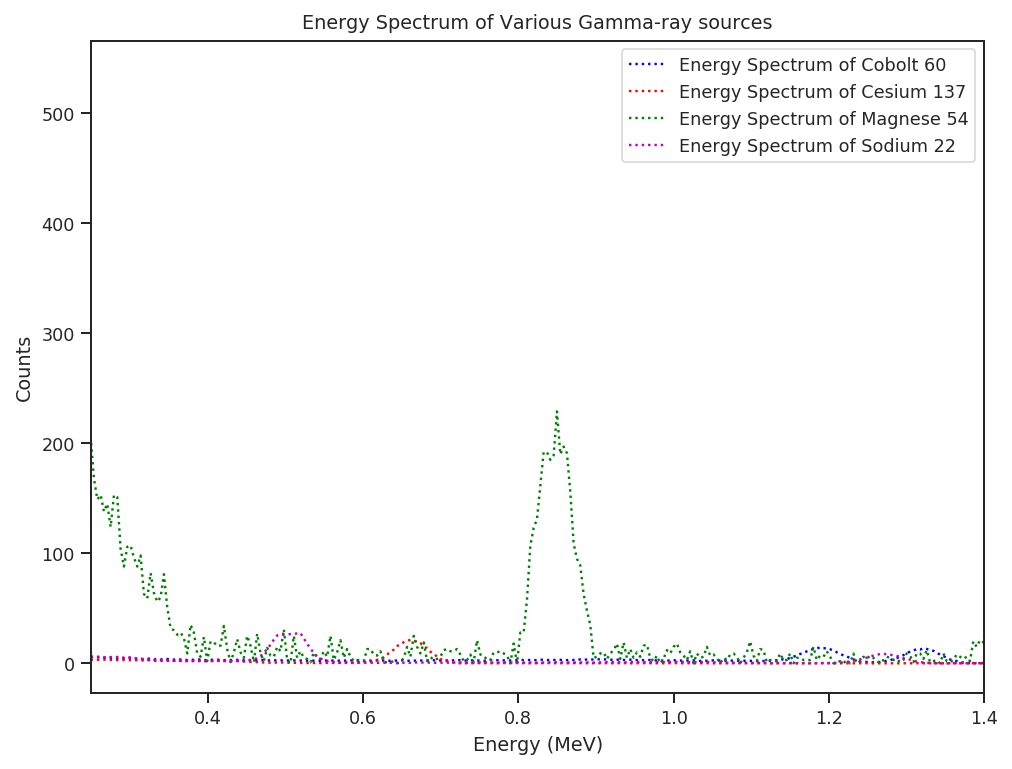

In [22]:
# Show all plots
# I have rescale the counts so that each peak is near the same height.

plt.figure(figsize=(8, 6))
plt.plot(linear_calib(co_data[0]), co_data[1]/100, 'b:', label="Energy Spectrum of Cobolt 60")
plt.plot(linear_calib(cs_data[0]), cs_data[1]/100, 'r:', label="Energy Spectrum of Cesium 137",)
plt.plot(linear_calib(mn_data2[0]), mn_data2[1], 'g:', label="Energy Spectrum of Magnese 54",)
plt.plot(linear_calib(na_data[0]), na_data[1]/100, 'm:', label="Energy Spectrum of Sodium 22")
plt.xlim(0.25,1.4)
plt.title("Energy Spectrum of Various Gamma-ray sources")
plt.legend()
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.show()

3425.674204836248 1.186354224693289 0.04506333779519926 89.72803374564131 0.0006337932107776764 0.0008396979977487357
837.5747990610374 2.878281899706518 0.05311667996917737 6.988169939840645 0.00051171902874905 0.0005117224057705952


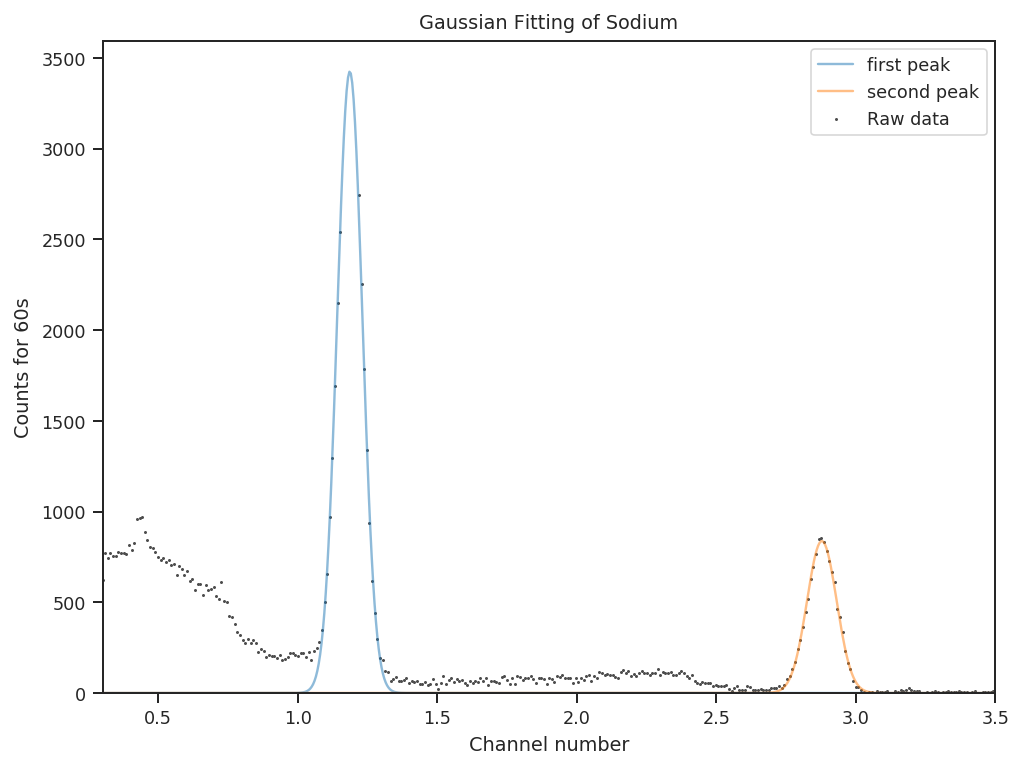

In [23]:
# Graph an example gaussian fit for a 2 peak source, show how the gaussians line up...

xlim = [na_data[0][0], 3.5]
xs = np.arange(*xlim, .005)

plt.figure(figsize=(8,6))
plt.scatter(na_data[0], na_data[1], s=0.5, c="0.3", label="Raw data")
plt.plot(xs, gauss_model(xs, *na_par1), label="first peak", alpha=0.5)
plt.plot(xs, gauss_model(xs, *na_par2), label="second peak", alpha=0.5)
plt.xlim(*xlim)
plt.ylim(0)

print(*na_par1, *np.sqrt(np.diag(na_cov1)))
print(*na_par2, *np.sqrt(np.diag(na_cov2)))
plt.title("Gaussian Fitting of Sodium")
plt.xlabel("Channel number")
plt.ylabel("Counts for 60s")
plt.legend()